# InfVis project work
---
This Python Script downloads an up-to-date dataset for **Covid-19**, gives first insights on the data and exports the data to the data folder.

The Data is from the **R**obert **K**och **I**nstitut downloaded over [ArcGis Hub](https://hub.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6?page=15976).

*Script was created on Python: 3.7.6 64-bit Kernel*


## Importing and installing of required packages

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

from datetime import datetime

import io               # file operations
import json

import ssl              # secure client-server connection
import requests         # html-requests

In [3]:
# Uncomment next 2 lines to install jsonmerge
#import sys
#!{sys.executable} -m pip install jsonmerge
from jsonmerge import Merger

SyntaxError: invalid syntax (<ipython-input-3-180450490a54>, line 3)

### Defining needed Variables
URL´s are created from stringconcat.

In [3]:
sourceURL = 'https://services7.arcgis.com/mOBPykOjAyBO2ZKk/arcgis/rest/services/RKI_COVID19/FeatureServer/0/query?'
objectIdsQuery = 'where=1%3D1&returnIdsOnly=true&f=json'
dataSetQuery = 'where=ObjectId+BETWEEN+0+AND+0' # just an example gets created later dynamically
dataQuery = '&outSR=4326&outFields=IdBundesland,Bundesland,Landkreis,Altersgruppe,AnzahlFall,AnzahlTodesfall,ObjectId,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn&f=json'

Create Json-Merger with custom merge strategie for the later requested data

In [4]:
jsonMergeSchema = {"properties":{"features":{"mergeStrategy":"append"}}}
dataMerger = Merger(jsonMergeSchema)

## Pulling the data from the internet

### First request
Check local data and Identifies downloadable data.

In [5]:
objectIdsRequest = requests.get(sourceURL + objectIdsQuery)
objectIdsRequest.status_code

200

In [6]:
objectIds = json.loads(objectIdsRequest.text)

numOfObjectIds = len(objectIds['objectIds'])

objectIdStart = objectIds['objectIds'][0]
objectIdEnd = objectIds['objectIds'][numOfObjectIds - 1]
print(f'Range of ObjectIds: [{objectIdStart}, {objectIdEnd}]')

Range of ObjectIds: [28705814, 28886605]


In [7]:
# Save objectIds
with open('../data/fobjectIds.json', 'w') as f:
    json.dump(objectIds, f)
    f.close()

### Secound request
Determines limit of data transfered by the server

In [8]:
dataRequest = requests.get(sourceURL + 'where=1%3D1' + dataQuery)
dataRequest.status_code

200

In [9]:
data = json.loads(dataRequest.text)
maxApiRequest = len(data['features'])

neededRequests = math.ceil(numOfObjectIds / maxApiRequest)

print(f'The download will require {neededRequests - 1} more requests due to the server limit of {maxApiRequest} features/request.')

The download will require 36 more requests due to the server limit of 5000 features/request.


Create all requests needed to get the data for every single ObjectId.  
**Ensure the cell above is run before this one is!**  
Otherwise it **WILL** cause data to be duplicated

In [10]:
i = 0
rangeLowerEnd = data['features'][maxApiRequest - 1]['attributes']['ObjectId'] + 1
rangeUpperEnd = rangeLowerEnd + maxApiRequest

while (i < neededRequests - 1): # neededRequests - 1 because of initial download
    dataSetQuery = f'where=ObjectId+BETWEEN+{rangeLowerEnd}+AND+{rangeUpperEnd}'
    temp_sourceURL = sourceURL + dataSetQuery + dataQuery
    print(i, f'Pulling ObjectIds: [{rangeLowerEnd}, {rangeUpperEnd}]')

    temp_dataRequest = requests.get(temp_sourceURL)
    if (temp_dataRequest.status_code > 200): # stop when a request isn´t working
        print(f'Error in request: {temp_dataRequest.status_code}')
        break
    temp_data = json.loads(temp_dataRequest.text)

    # append new data to already downloaded one
    data = dataMerger.merge(data, temp_data)

    temp_dataLength = len(data['features'])
    t_le = data['features'][0]['attributes']['ObjectId']
    t_ue = data['features'][temp_dataLength - 1]['attributes']['ObjectId']
    print(f'Total collected features: {temp_dataLength} From ObjectIds: [{t_le}, {t_ue}]')

    rangeLowerEnd = rangeUpperEnd + 1
    rangeUpperEnd += maxApiRequest + 1
    if (rangeUpperEnd > objectIdEnd):
        rangeUpperEnd = objectIdEnd
    i += 1

print('Done')

0 Pulling ObjectIds: [28710814, 28715814]
Total collected features: 10000 From ObjectIds: [28705814, 28715813]
1 Pulling ObjectIds: [28715815, 28720815]
Total collected features: 15000 From ObjectIds: [28705814, 28720814]
2 Pulling ObjectIds: [28720816, 28725816]
Total collected features: 20000 From ObjectIds: [28705814, 28725815]
3 Pulling ObjectIds: [28725817, 28730817]
Total collected features: 25000 From ObjectIds: [28705814, 28730816]
4 Pulling ObjectIds: [28730818, 28735818]
Total collected features: 30000 From ObjectIds: [28705814, 28735817]
5 Pulling ObjectIds: [28735819, 28740819]
Total collected features: 35000 From ObjectIds: [28705814, 28740818]
6 Pulling ObjectIds: [28740820, 28745820]
Total collected features: 40000 From ObjectIds: [28705814, 28745819]
7 Pulling ObjectIds: [28745821, 28750821]
Total collected features: 45000 From ObjectIds: [28705814, 28750820]
8 Pulling ObjectIds: [28750822, 28755822]
Total collected features: 50000 From ObjectIds: [28705814, 28755821]
9

In [11]:
print('Available columns')
for item in data['fields']:
    print(item['name'])

Available columns
IdBundesland
Bundesland
Landkreis
Altersgruppe
AnzahlFall
AnzahlTodesfall
ObjectId
Meldedatum
IdLandkreis
Datenstand
NeuerFall
NeuerTodesfall
Refdatum
NeuGenesen
AnzahlGenesen
IstErkrankungsbeginn


Print out an example feature to see the sturcture of the data

In [12]:
print('Entries: ', len(data['features']))
print('Structure: ', data['features'][0])
print('Latest data: ', data['features'][0]['attributes']['Datenstand'])

Entries:  180757
Structure:  {'attributes': {'IdBundesland': 1, 'Bundesland': 'Schleswig-Holstein', 'Landkreis': 'SK Flensburg', 'Altersgruppe': 'A05-A14', 'AnzahlFall': 1, 'AnzahlTodesfall': 0, 'ObjectId': 28705814, 'Meldedatum': 1597449600000, 'IdLandkreis': '01001', 'Datenstand': '17.08.2020, 00:00 Uhr', 'NeuerFall': 0, 'NeuerTodesfall': -9, 'Refdatum': 1597449600000, 'NeuGenesen': -9, 'AnzahlGenesen': 0, 'IstErkrankungsbeginn': 0}}
Latest data:  17.08.2020, 00:00 Uhr


Testing commulated data for comparison with numbers from the internet

In [13]:
totalCases = 0
for entry in data['features']:
    totalCases += entry['attributes']['AnzahlFall']
totalCases

223964

In [14]:
shDeaths = 0
shRecovered = 0
shEntries = 0
for entry in data['features']:
    if entry['attributes']['Bundesland'] == 'Schleswig-Holstein':
        shDeaths += entry['attributes']['AnzahlTodesfall']
        shRecovered += entry['attributes']['AnzahlGenesen']
        shEntries += 1
print('Deaths:', shDeaths, 'Recovered:', shRecovered, 'Entries:', shEntries)

Deaths: 158 Recovered: 3351 Entries: 3424


## Creating Pandas DataFrame

In [15]:
def display_n(df,n): 
    with pd.option_context('display.max_rows',n*2):
        display(df)

In [16]:
dfx = pd.DataFrame.from_dict(data['features'])
display_n(dfx, 2)

,attributes
0,"{'IdBundesland': 1, 'Bundesland': 'Schleswig-H..."
1,"{'IdBundesland': 1, 'Bundesland': 'Schleswig-H..."
...,...
180755,"{'IdBundesland': 16, 'Bundesland': 'Thüringen'..."
180756,"{'IdBundesland': 16, 'Bundesland': 'Thüringen'..."


In [17]:
# turning the collumn attributes in seperated collumns
for rowid in data['fields']:
    dfx[rowid['name']] = dfx.apply(lambda row: row.loc['attributes'][rowid['name']], axis=1)
dfx = dfx.drop(['attributes'], axis=1)

In [18]:
display_n(dfx, 2)

,IdBundesland,Bundesland,Landkreis,Altersgruppe,AnzahlFall,AnzahlTodesfall,ObjectId,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn
0,1,Schleswig-Holstein,SK Flensburg,A05-A14,1,0,28705814,1597449600000,01001,"17.08.2020, 00:00 Uhr",0,-9,1597449600000,-9,0,0
1,1,Schleswig-Holstein,SK Flensburg,A15-A34,1,0,28705815,1584144000000,01001,"17.08.2020, 00:00 Uhr",0,-9,1584316800000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180755,16,Thüringen,LK Altenburger Land,A80+,2,0,28886604,1590624000000,16077,"17.08.2020, 00:00 Uhr",0,-9,1590624000000,0,2,0
180756,16,Thüringen,LK Altenburger Land,A80+,1,0,28886605,1591660800000,16077,"17.08.2020, 00:00 Uhr",0,-9,1591660800000,0,1,0


---
### Export origninal data to CSV

In [19]:
dfx.to_csv('../data/rki_covid19.csv', index=False, encoding='utf-8')

---
### Overview over the total number of cases

In [20]:
frame_byBundesland = dfx.groupby(['Bundesland'])['AnzahlFall', 'AnzahlTodesfall', 'AnzahlGenesen'].sum().reset_index()
frame_byBundesland = frame_byBundesland.set_index('Bundesland')

In [21]:
frame_byBundesland

,AnzahlFall,AnzahlTodesfall,AnzahlGenesen
Bundesland,,,
Baden-Württemberg,38505,1859,35530
Bayern,52974,2630,48626
Berlin,10251,224,9289
Brandenburg,3703,169,3423
Bremen,1843,56,1732
Hamburg,5887,264,5161
Hessen,13483,526,11778
Mecklenburg-Vorpommern,972,20,873
Niedersachsen,15422,656,13882


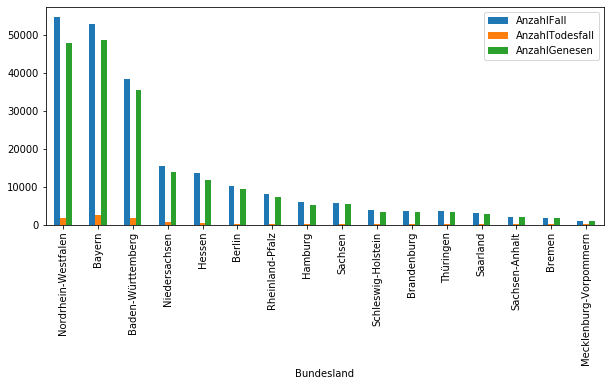

In [22]:
frame_byBundesland = frame_byBundesland.sort_values(by='AnzahlFall', ascending=False)
ax = frame_byBundesland.plot.bar(figsize=(10,4))

---
### Aggregate data for final visualisiation

In [23]:
# Dropping columns that are not relevant and collapsing subgroups one by one
dfx_slim = dfx.drop(columns=['IdBundesland', 'ObjectId', 'NeuerFall', 'NeuerTodesfall', 'IstErkrankungsbeginn', 'NeuGenesen', 'Meldedatum', 'Datenstand', 'IdLandkreis']).groupby(['Refdatum', 'Bundesland', 'Landkreis', 'Altersgruppe']).sum().groupby(['Refdatum', 'Bundesland', 'Landkreis']).sum().groupby(['Refdatum', 'Bundesland']).sum()

In [24]:
dfx_slim

AnzahlFall  AnzahlTodesfall  AnzahlGenesen
Refdatum      Bundesland                                                     
1579046400000 Berlin                        1                0              1
1579219200000 Bayern                        1                1              0
              Schleswig-Holstein            1                0              1
1579478400000 Nordrhein-Westfalen           1                0              1
1579737600000 Bayern                        2                0              2
...                                       ...              ...            ...
1597536000000 Hessen                       24                0              0
              Niedersachsen                 1                0              0
              Nordrhein-Westfalen          89                0              0
              Rheinland-Pfalz               5                0              0
              Schleswig-Holstein            2                0              0

[2772 rows x 3 columns]

In [25]:
# Uncomment next line to get uncumulated data which == new reported Cases
#dfx_slim.to_csv('../web/data/rki_slim.csv', index=True, encoding='utf-8')

Cumulate the data by state and date

In [26]:
dfx_slim_cum = dfx_slim.groupby(['Bundesland', 'Refdatum']).sum().groupby(level=[0]).cumsum()
dfx_slim_cum

AnzahlFall  AnzahlTodesfall  AnzahlGenesen
Bundesland        Refdatum                                                 
Baden-Württemberg 1580688000000           1                1              0
                  1580774400000           2                1              1
                  1581292800000           3                1              2
                  1581552000000           4                1              3
                  1581638400000           5                2              3
...                                     ...              ...            ...
Thüringen         1597017600000        3462              186           3209
                  1597104000000        3470              186           3209
                  1597190400000        3483              186           3209
                  1597276800000        3489              186           3209
                  1597363200000        3497              186           3209

[2772 rows x 3 columns]

In [27]:
displayState = "Bayern"
display_n(dfx_slim_cum.groupby(['Bundesland']).get_group(displayState), 10)

AnzahlFall  AnzahlTodesfall  AnzahlGenesen
Bundesland Refdatum                                                 
Bayern     1579219200000           1                1              0
           1579737600000           3                1              2
           1579824000000           4                1              3
           1579910400000           5                1              4
           1580083200000           7                1              6
...                              ...              ...            ...
           1597104000000       52459             2630          48626
           1597190400000       52613             2630          48626
           1597276800000       52769             2630          48626
           1597363200000       52920             2630          48626
           1597449600000       52974             2630          48626

[198 rows x 3 columns]

In [28]:
dfx_slim_cum = dfx_slim_cum.reset_index().set_index('Refdatum')
display_n(dfx_slim_cum, 2)

,Bundesland,AnzahlFall,AnzahlTodesfall,AnzahlGenesen
Refdatum,,,,
1580688000000,Baden-Württemberg,1,1,0
1580774400000,Baden-Württemberg,2,1,1
...,...,...,...,...
1597276800000,Thüringen,3489,186,3209
1597363200000,Thüringen,3497,186,3209


---
### Export aggregated data for further visualisation

In [29]:
dfx_slim_cum.to_csv('../web/data/rki_slim_cum.csv', index=True, encoding='utf-8')